# Hourly data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# File paths
obs_file_paths = {
    'norah_head': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/norah_1h.csv',
    'richmond_raaf': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/richmond_1h.csv',
    'badgery': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/badgery_1h.csv',
    'sydney_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/sydney_1h.csv',
    'bankstown_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/bankstown_1h.csv'
}

germany_model_file_paths = {
    'norah_head': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Norah_Head_AWS_z10.csv',
    'richmond_raaf': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Richmond_RAAF_z10.csv',
    'badgery': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Badgerys_Creek_AWS_z10.csv',
    'sydney_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Sydney_Airport_AMO_z10.csv',
    'bankstown_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Bankstown_Airport_AWS_z10.csv'
}

uk_model_file_paths = {
    'norah_head': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Norah_Head_AWS_z10.csv',
    'richmond_raaf': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Richmond_RAAF_z10.csv',
    'badgery': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Badgerys_Creek_AWS_z10.csv',
    'sydney_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Sydney_Airport_AMO_z10.csv',
    'bankstown_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Bankstown_Airport_AWS_z10.csv'
}

# Column names and date range
obs_column = 'Precipitation'
model_column = 'value'
start_date = '2020-03-01'
end_date = '2021-02-28'
stations = list(obs_file_paths.keys())


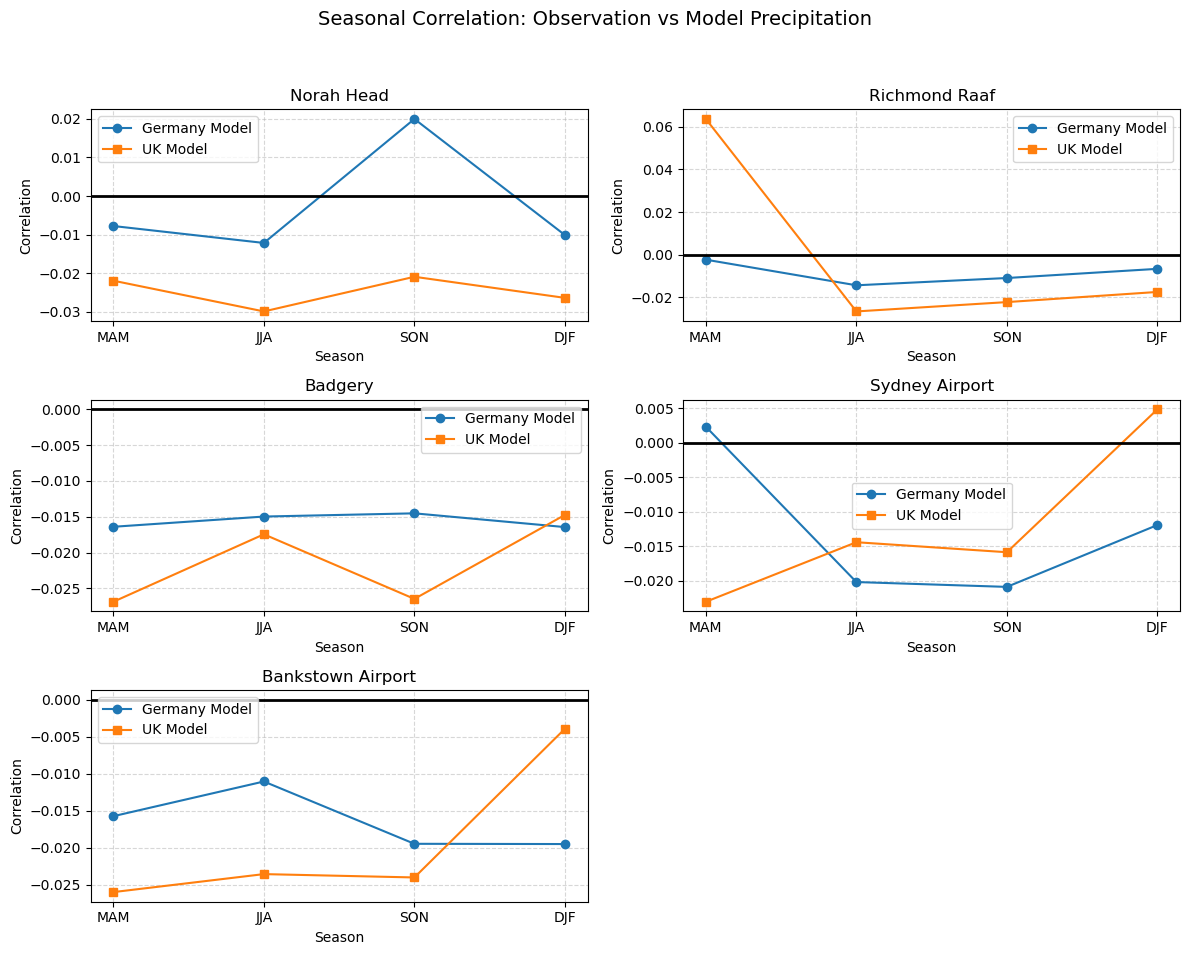

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Define seasonal mapping
def get_season(month):
    if month in [3, 4, 5]:
        return 'MAM'
    elif month in [6, 7, 8]:
        return 'JJA'
    elif month in [9, 10, 11]:
        return 'SON'
    else:
        return 'DJF'

# Unified function to load and preprocess
def load_and_segregate(file_path, value_column, start_date, end_date, is_obs=False):
    time_col = 'Time' if is_obs else 'time'
    df = pd.read_csv(file_path, parse_dates=[time_col])
    df = df.set_index(time_col)
    df = df.loc[start_date:end_date]
    df['season'] = df.index.month.map(get_season)
    df = df.rename(columns={value_column: 'value'})
    return df

# Parameters
start_date = '2020-03-01'
end_date = '2021-02-28'
obs_column = 'Precipitation'
model_column = 'value'
seasons = ['MAM', 'JJA', 'SON', 'DJF']

# Create figure
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axs = axs.flatten()

# Plot counter
plot_idx = 0

# Loop over stations
for station in stations:
    # Load data
    obs_df = load_and_segregate(obs_file_paths[station], obs_column, start_date, end_date, is_obs=True)
    germany_df = load_and_segregate(germany_model_file_paths[station], model_column, start_date, end_date)
    uk_df = load_and_segregate(uk_model_file_paths[station], model_column, start_date, end_date)

    # Merge
    merged_germany = obs_df[['value', 'season']].join(germany_df[['value']], lsuffix='_obs', rsuffix='_germany')
    merged_uk = obs_df[['value', 'season']].join(uk_df[['value']], lsuffix='_obs', rsuffix='_uk')

    # Compute correlation per season
    germany_corr, uk_corr = [], []
    for s in seasons:
        g = merged_germany[merged_germany['season'] == s].dropna()
        u = merged_uk[merged_uk['season'] == s].dropna()

        germany_corr.append(g['value_obs'].corr(g['value_germany']))
        uk_corr.append(u['value_obs'].corr(u['value_uk']))

    # Plot
    ax = axs[plot_idx]
    ax.plot(seasons, germany_corr, marker='o', label='Germany Model')
    ax.plot(seasons, uk_corr, marker='s', label='UK Model')
    ax.set_title(f'{station.replace("_", " ").title()}')
    # ax.set_ylim(-1, 1)
    ax.set_xlabel('Season')
    ax.set_ylabel('Correlation')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=2)

    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    plot_idx += 1

# Hide unused subplot (if any)
if len(axs) > len(stations):
    for ax in axs[len(stations):]:
        ax.set_visible(False)

plt.suptitle('Seasonal Correlation: Observation vs Model Precipitation', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Daily data

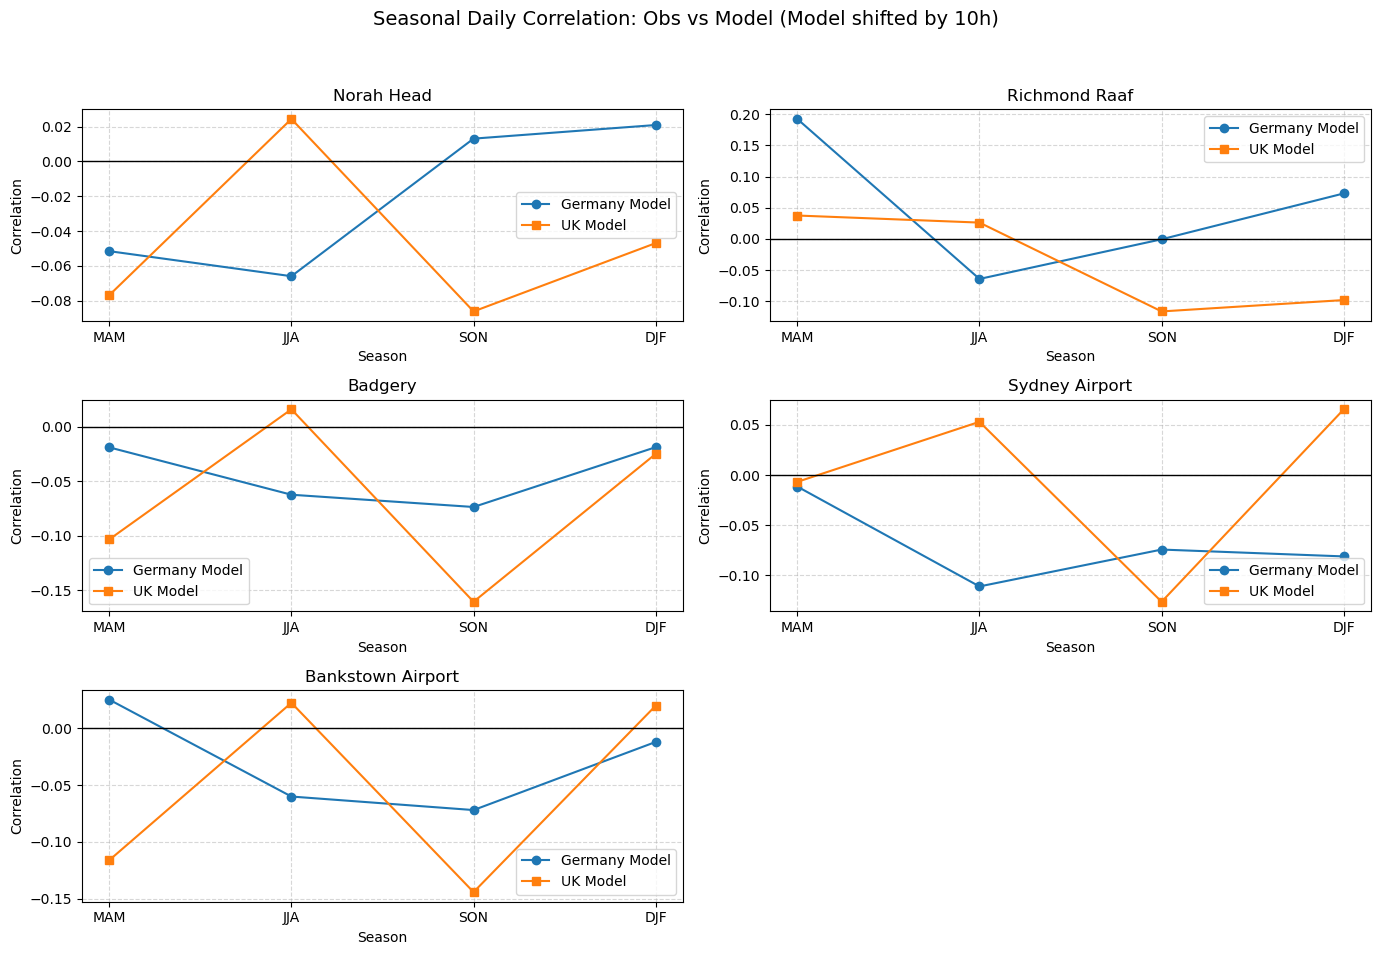

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define seasonal mapping function
def get_season(month):
    if month in [3, 4, 5]:
        return 'MAM'
    elif month in [6, 7, 8]:
        return 'JJA'
    elif month in [9, 10, 11]:
        return 'SON'
    else:
        return 'DJF'

# Preprocessing function
def load_and_process(file_path, value_column, start_date, end_date, is_obs=False):
    time_col = 'Time' if is_obs else 'time'
    df = pd.read_csv(file_path, parse_dates=[time_col])
    
    # Rename and set datetime index
    df = df.rename(columns={value_column: 'value'})
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.set_index(time_col)
    
    # Shift model data to make 10:00 the new 00:00
    if not is_obs:
        df.index = df.index - pd.Timedelta(hours=10)

    # Trim to date range
    df = df.loc[start_date:end_date]
    
    # Resample to daily total
    df_daily = df.resample('D').sum()
    
    # Add season labels
    df_daily['season'] = df_daily.index.month.map(get_season)
    
    return df_daily

# Input configuration
obs_file_paths = {
    'norah_head': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/norah_1h.csv',
    'richmond_raaf': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/richmond_1h.csv',
    'badgery': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/badgery_1h.csv',
    'sydney_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/sydney_1h.csv',
    'bankstown_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/bankstown_1h.csv'
}

germany_model_file_paths = {
    'norah_head': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Norah_Head_AWS_z10.csv',
    'richmond_raaf': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Richmond_RAAF_z10.csv',
    'badgery': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Badgerys_Creek_AWS_z10.csv',
    'sydney_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Sydney_Airport_AMO_z10.csv',
    'bankstown_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Bankstown_Airport_AWS_z10.csv'
}

uk_model_file_paths = {
    'norah_head': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Norah_Head_AWS_z10.csv',
    'richmond_raaf': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Richmond_RAAF_z10.csv',
    'badgery': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Badgerys_Creek_AWS_z10.csv',
    'sydney_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Sydney_Airport_AMO_z10.csv',
    'bankstown_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Bankstown_Airport_AWS_z10.csv'
}

# Constants
start_date = '2020-03-01'
end_date = '2021-02-28'
stations = list(obs_file_paths.keys())
seasons = ['MAM', 'JJA', 'SON', 'DJF']

# Plot setup
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
axs = axs.flatten()

# Main loop over stations
for i, station in enumerate(stations):
    # Load and preprocess data
    obs_df = load_and_process(obs_file_paths[station], 'Precipitation', start_date, end_date, is_obs=True)
    germany_df = load_and_process(germany_model_file_paths[station], 'value', start_date, end_date)
    uk_df = load_and_process(uk_model_file_paths[station], 'value', start_date, end_date)
    
    # Merge obs with model data
    df_merged = obs_df[['value', 'season']].rename(columns={'value': 'obs'})
    df_merged = df_merged.join(germany_df['value'].rename('germany'))
    df_merged = df_merged.join(uk_df['value'].rename('uk'))
    
    # Compute correlation for each season
    germany_corrs, uk_corrs = [], []
    for season in seasons:
        seasonal_data = df_merged[df_merged['season'] == season]

        # Germany model
        df_germ = seasonal_data[['obs', 'germany']].dropna()
        if len(df_germ) > 1:
            r, _ = pearsonr(df_germ['obs'], df_germ['germany'])
            germany_corrs.append(r)
        else:
            germany_corrs.append(None)

        # UK model
        df_uk = seasonal_data[['obs', 'uk']].dropna()
        if len(df_uk) > 1:
            r, _ = pearsonr(df_uk['obs'], df_uk['uk'])
            uk_corrs.append(r)
        else:
            uk_corrs.append(None)

    # Plot
    ax = axs[i]
    ax.plot(seasons, germany_corrs, marker='o', label='Germany Model')
    ax.plot(seasons, uk_corrs, marker='s', label='UK Model')
    ax.set_title(station.replace('_', ' ').title())
    ax.set_ylabel('Correlation')
    ax.set_xlabel('Season')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend()
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Hide any unused subplots
for j in range(len(stations), len(axs)):
    axs[j].axis('off')

plt.suptitle('Seasonal Daily Correlation: Obs vs Model (Model shifted by 10h)', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# annual correlation

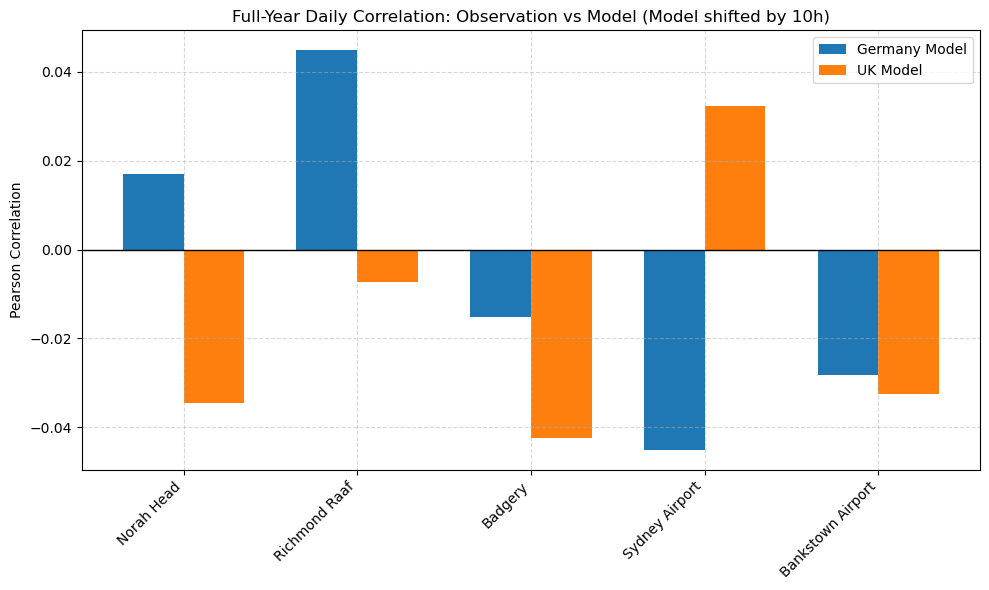

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Preprocessing function
def load_and_process(file_path, value_column, start_date, end_date, is_obs=False):
    time_col = 'Time' if is_obs else 'time'
    df = pd.read_csv(file_path, parse_dates=[time_col])
    
    # Rename and set datetime index
    df = df.rename(columns={value_column: 'value'})
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.set_index(time_col)
    
    # Shift model data to make 10:00 the new 00:00
    if not is_obs:
        df.index = df.index - pd.Timedelta(hours=10)
    
    # Trim to date range
    df = df.loc[start_date:end_date]
    
    # Resample to daily total
    df_daily = df.resample('D').sum()
    
    return df_daily

# Input configuration
obs_file_paths = {
    'norah_head': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/norah_1h.csv',
    'richmond_raaf': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/richmond_1h.csv',
    'badgery': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/badgery_1h.csv',
    'sydney_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/sydney_1h.csv',
    'bankstown_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/Processed/Sydney/bankstown_1h.csv'
}

germany_model_file_paths = {
    'norah_head': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Norah_Head_AWS_z10.csv',
    'richmond_raaf': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Richmond_RAAF_z10.csv',
    'badgery': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Badgerys_Creek_AWS_z10.csv',
    'sydney_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Sydney_Airport_AMO_z10.csv',
    'bankstown_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/germney_model_sydney_z10/germany_node_Bankstown_Airport_AWS_z10.csv'
}

uk_model_file_paths = {
    'norah_head': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Norah_Head_AWS_z10.csv',
    'richmond_raaf': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Richmond_RAAF_z10.csv',
    'badgery': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Badgerys_Creek_AWS_z10.csv',
    'sydney_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Sydney_Airport_AMO_z10.csv',
    'bankstown_airport': '/home/561/lk5320/hk25-AusNode-ExtremePrecipitation/Data/uk_model_sydney_z10/uk_node_Bankstown_Airport_AWS_z10.csv'
}

# Constants
start_date = '2020-03-01'
end_date = '2021-02-28'
stations = list(obs_file_paths.keys())

# Prepare lists for plotting
germany_corrs = []
uk_corrs = []
station_labels = []

# Main loop over stations
for station in stations:
    # Load and preprocess data
    obs_df = load_and_process(obs_file_paths[station], 'Precipitation', start_date, end_date, is_obs=True)
    germany_df = load_and_process(germany_model_file_paths[station], 'value', start_date, end_date)
    uk_df = load_and_process(uk_model_file_paths[station], 'value', start_date, end_date)
    
    # Merge into a single dataframe
    df_merged = obs_df.rename(columns={'value': 'obs'})
    df_merged = df_merged.join(germany_df['value'].rename('germany'))
    df_merged = df_merged.join(uk_df['value'].rename('uk'))

    # Drop NaNs
    df_clean = df_merged[['obs', 'germany', 'uk']].dropna()

    # Compute correlations
    if len(df_clean) > 1:
        r_germany, _ = pearsonr(df_clean['obs'], df_clean['germany'])
        r_uk, _ = pearsonr(df_clean['obs'], df_clean['uk'])
    else:
        r_germany, r_uk = None, None
    
    germany_corrs.append(r_germany)
    uk_corrs.append(r_uk)
    station_labels.append(station.replace('_', ' ').title())

# Plotting
x = range(len(station_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width/2 for i in x], germany_corrs, width=width, label='Germany Model')
ax.bar([i + width/2 for i in x], uk_corrs, width=width, label='UK Model')

ax.set_xticks(x)
ax.set_xticklabels(station_labels, rotation=45, ha='right')
ax.set_ylabel('Pearson Correlation')
ax.set_title('Full-Year Daily Correlation: Observation vs Model (Model shifted by 10h)')
ax.axhline(0, color='black', linewidth=1)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
plt.tight_layout()
plt.show()
